### 导包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight as cw

from keras import Sequential

from keras.models import Model

from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding,BatchNormalization,Add,concatenate,Flatten
from keras.layers import Conv1D,Conv2D,Convolution1D,MaxPool1D,SeparableConv1D,SpatialDropout1D,GlobalAvgPool1D,GlobalMaxPool1D,GlobalMaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.layers import MaxPooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D

from keras.optimizers import RMSprop,Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
D:\software\Anaconda\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\software\Anaconda\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\software\Anaconda\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\software\Anaconda\anaconda\lib\site-packages\tensorflow\python

In [2]:
# 定义一个功能函数
def date_time(x):
    if x==1:
        return "Timestamp:{:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.now())
    if x==2:
        return "Timestamp:{:%Y-%b-%d %H:%M:%S}".format(datetime.datetime.now())
    if x==3:
        return "Date now:%s" % datetime.datetime.now()
    if x==4:
        return "Date today:%s" %datetime.date.today()

### 导入数据

In [3]:
#train_df = pd.read_csv("./sms_spam/sms_train.txt",encoding="utf-8",header=None,sep="\t",names=["label","text"])
train_df = pd.read_csv("./sms_spam/spam.csv",encoding="latin-1",delimiter=",")
train_df.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Text(0.5, 0, 'Label')

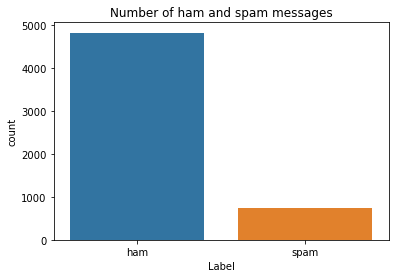

In [4]:
# 统计一下
sns.countplot(train_df["label"])
plt.title("Number of ham and spam messages")
plt.xlabel("Label")

### 标签数据处理

In [5]:
# 对标签进行处理
#  LabelEncoder 是对不连续的数字或者文本进行编号
# LabelEncoder可以将标签分配一个0—n_classes-1之间的编码

x_train = train_df["text"]
y_train = train_df["label"]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = y_train.reshape(-1,1)

### 文本数据处理

In [6]:
# 分词器Tokenizer   Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类
       # 类方法
           # fit_on_texts(texts) :texts用于训练的文本列表
          # texts_to_sequences(texts):texts待转为序列的文本列表 返回值:序列的列表，列表中的每个序列对应于一段输入文本

# 填充序列pad_sequences  将长为nb_smaples的序列转换为(nb_samples,nb_timesteps)2Dnumpy attay.如果提供maxlen,nb_timesteps=maxlen,否则其值为最长序列的长度。
# 其它短于该长度的序列都会在后部填充0以达到该长度。长与nb_timesteps的序列会被阶段，以使其匹配该目标长度。

#max_words = 1000
#max_len = 150
max_words = len(set(" ".join(x_train).split()))
max_len = x_train.apply(lambda x:len(x)).max()


tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(x_train)

sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

- sklearn.utils.class_weight 样本均衡
    - 当我们的数据，有多个类别，每个类别的数据量有很大差距时，这时需要对每个类别的样本做一次均衡，这样会让每个类别的特征都在一定程度上被模型学习


In [7]:
# 计算各个类的weights
def get_weight(y):
    class_weight_current = cw.compute_class_weight("balanced",np.unique(y),y)
    return class_weight_current

class_weight = get_weight(y_train.flatten())

- ModelCheckpoint：
    - 作用：该回调函数将在每个epoch后保存模型到filepath
    - 参数：
        - filename:字符串，保存模型的路径，filepath可以是格式化的字符串，里面的
        - monitor:需要监视的值，通常为:val_acc或val_loss或acc或loss
        - verbose:信息展示模型，0或1。默认为0表示不输出该信息，为1表示输出epoch模型保存信息。
        - save_best_only:当设置为Trur时，将只保存在验证集上性能最好的模型
        - mode:"auto","min","max"之一，在save_best_only=True时决定性能最佳模型的评判准则。
        - save_weights_only:若设置为True时，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）
        - period:CheckPoint之间的间隔的epoch数
        
- EarlyStopping：
    - 作用：当监测值不再改善时，该回调函数将中止训练
    - 参数：
        - monitor:需要监视的量，通常为val_acc或val_loss或acc或loss
        - patience:当early stop被激活（如发现loss相比上patience个epoch训练没有下降），则经过patience个epoch后停止训练。
        - verbose:信息展示模型
        - mode:"auto","min","max"之一，在min模式下，如果检测值停止下降则中止训练。在max模式下，当检测值不再上升则停止训练。
        
- ReduceLROnPlateau:
    - 作用：当评价指标不再提升时，减少学习率。当学习停滞时，减少2倍或10倍的学习率通常能够获得较好的效果。该回调函数检测指标的情况，如果在patience个epoch中看不到模型性能提升，则减少学习率。
    - 参数：
        - monitor:被监测的量
        - factor:每次减少学习率的因子，学习率将以lr=lr*factor的形式被技术那好
        - patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
        - mode:"auto","min","max"之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少
        - epsilon:阈值，用来确定是否进入检测值的“平原区”
        - cooldown:学习率减少后，会经过cooldown个epoch才重新进行正常操作
        - min_lr:学习率的下限。

In [8]:
print("Setting Callbacks")

checkpoint = ModelCheckpoint("model.hdf5",
                                                     monitor="val_acc",
                                                     save_best_only=True,
                                                     mode="max")

early_stopping = EarlyStopping(monitor="val_loss",
                                                     patience=2,
                                                     verbose=1,
                                                     restore_best_weights=True,
                                                     mode="min")

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                                      factor=0.6,
                                                      patience=1,
                                                      verbose=1,
                                                      mode="min")

callbacks=[checkpoint,early_stopping,reduce_lr]
print("Set Callbacks at",date_time(1))

Setting Callbacks
Set Callbacks at Timestamp:2019-10-08 16:34:11


### 定义深度学习模型

In [9]:
# 定义RNN模型
def RNN():
    model = Sequential()
    
    model.add(Embedding(max_words,50,input_length=max_len))
    model.add(LSTM(64))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation="relu"))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1,activation="sigmoid"))
    
    model.summary()
    
    return model

In [10]:
# 定义CNN模型
def CNN():
    model=Sequential()
    
    model.add(Embedding(max_words,50,input_length=max_len))
    
    model.add(Conv1D(64,3,padding="valid",activation="relu",strides=1))
    model.add(GlobalMaxPooling1D())

    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation="relu"))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1,activation="sigmoid"))

    model.summary()
    return model

In [11]:
# 画曲线
def plot_performance(history=None,figure_directory=None,ylim_pad=[0,0]):
    xlabel="Epoch"
    legends=["Training","Validation"]
    
    plt.figure(figsize=(20,5))
    
    y1=history.history["accuracy"]
    y2=history.history["val_accuracy"]
    
    min_y=min(min(y1),min(y2))-ylim_pad[0]
    max_y=max(max(y1),max(y2))+ylim_pad[0]
    
    plt.subplot(121)
    
    plt.plot(y1)
    plt.plot(y2)
    
    plt.title("Model Accuracy\n"+date_time(1),fontsize=17)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel("Accuracy",fontsize=15)
    plt.ylim(min_y,max_y)
    plt.legend(legends,loc="upper left")
    plt.grid()
    
    y1=history.history["loss"]
    y2=history.history["val_loss"]
    
    min_y=min(min(y1),min(y2))-ylim_pad[1]
    max_y=max(max(y1),max(y2))+ylim_pad[1]
    
    plt.subplot(122)
    
    plt.plot(y1)
    plt.plot(y2)
    
    plt.title("Model Loss:\n"+date_time(1),fontsize=17)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel("Loss",fontsize=15)
    plt.ylim(min_y,max_y)
    plt.legend(legends,loc="upper left")
    plt.grid()
    plt.show()

### RNN

In [12]:
rnn_model = RNN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 910, 50)           779100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [13]:
loss = "binary_crossentropy"
metrics=["accuracy"]

In [14]:
# RNN模型训练
print("Starting...\n")

start_time = time.time()
print(date_time(1))
learning_rate=0.001
optimizer=Adam(learning_rate)

print("\n\nCompliling Model...\n")
rnn_model.compile(optimizer=optimizer,
                                 loss=loss,
                                 metrics=metrics)

verbose = 1
epochs=100
batch_size=128
validation_split=0.2
print("Trainning Model...\n")

rnn_history=rnn_model.fit(sequences_matrix,
                                            y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            verbose=1,
                                            callbacks=callbacks,
                                            validation_split=validation_split,
                                            class_weight=class_weight)

elapsed_time=time.time()-start_time
elapsed_time=time.strftime("%H:%M:%S",time.gmtime(elapsed_time))

print("\nElapsed Time: "+elapsed_time)
print("Completed Model Training",date_time(1))

Starting...

Timestamp:2019-10-08 16:34:12


Compliling Model...

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trainning Model...


Train on 4457 samples, validate on 1115 samples
Epoch 1/100
4457/4457 [==============================] - 45s 10ms/step - loss: 0.8078 - accuracy: 0.6074 - val_loss: 0.4937 - val_accuracy: 0.8700
Epoch 2/100
4457/4457 [==============================] - 37s 8ms/step - loss: 0.4239 - accuracy: 0.8142 - val_loss: 0.3653 - val_accuracy: 0.8700
Epoch 3/100
4457/4457 [==============================] - 36s 8ms/step - loss: 0.1575 - accuracy: 0.9637 - val_loss: 0.2177 - val_accuracy: 0.9256
Epoch 4/100
4457/4457 [==============================] - 35s 8ms/step - loss: 0.0762 - accuracy: 0.9879 - val_loss: 0.2155 - val_accuracy: 0.8969
Epoch 5/100
4457/4457 [==============================] - 36s 8ms/step - loss: 0.0435 - accuracy: 0.9935 - val_loss: 0.1521 - val_accuracy: 0.9426
Epoch 6/100
4457/4457 [=================

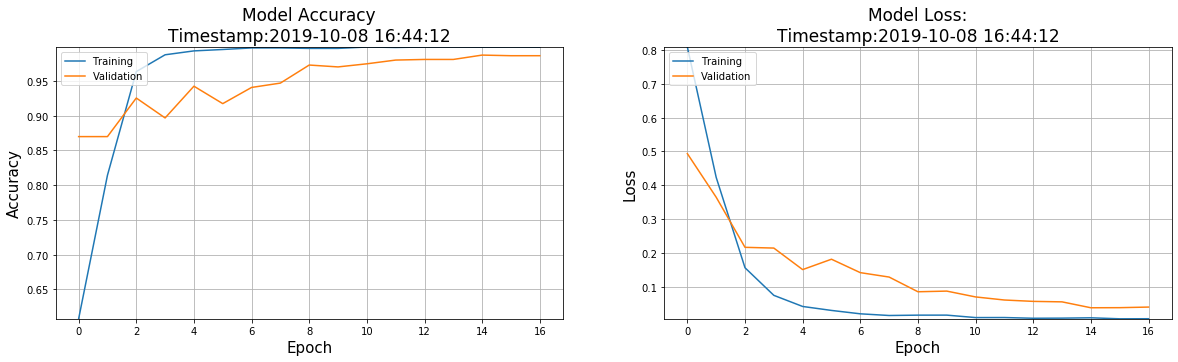

In [15]:
# 可视化
plot_performance(history=rnn_history)

### CNN

In [16]:
cnn_model = CNN()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 910, 50)           779100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 908, 64)           9664      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [21]:
# CNN模型训练
print("Starting...\n")

start_time = time.time()
print(date_time(1))


print("\n\nCompliling Model...\n")
learning_rate=0.001
optimizer=Adam(learning_rate)
cnn_model.compile(optimizer=optimizer,
                                 loss=loss,
                                 metrics=metrics)

verbose = 1
epochs=100
batch_size=64
validation_split=0.2
print("Trainning Model...\n")

cnn_history=cnn_model.fit(sequences_matrix,
                                            y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            verbose=1,
                                            callbacks=callbacks,
                                            validation_split=validation_split,
                                            class_weight=class_weight)

elapsed_time=time.time()-start_time
elapsed_time=time.strftime("%H:%M:%S",time.gmtime(elapsed_time))

print("\nElapsed Time: "+elapsed_time)
print("Completed Model Training",date_time(1))

Starting...

Timestamp:2019-10-08 17:19:02


Compliling Model...

Trainning Model...

Train on 4457 samples, validate on 1115 samples
Epoch 1/100
4457/4457 [==============================] - 2s 527us/step - loss: 0.1648 - accuracy: 0.9466 - val_loss: 0.4399 - val_accuracy: 0.8700
Epoch 2/100
4457/4457 [==============================] - 1s 288us/step - loss: 0.1118 - accuracy: 0.9630 - val_loss: 0.3781 - val_accuracy: 0.8700
Epoch 3/100
4457/4457 [==============================] - 1s 285us/step - loss: 0.0773 - accuracy: 0.9762 - val_loss: 0.2767 - val_accuracy: 0.8843
Epoch 4/100
4457/4457 [==============================] - 1s 284us/step - loss: 0.0635 - accuracy: 0.9805 - val_loss: 0.1647 - val_accuracy: 0.9381
Epoch 5/100
4457/4457 [==============================] - 1s 290us/step - loss: 0.0590 - accuracy: 0.9834 - val_loss: 0.1126 - val_accuracy: 0.9570
Epoch 6/100
4457/4457 [==============================] - 1s 285us/step - loss: 0.0359 - accuracy: 0.9897 - val_loss: 0.0789 - val_a

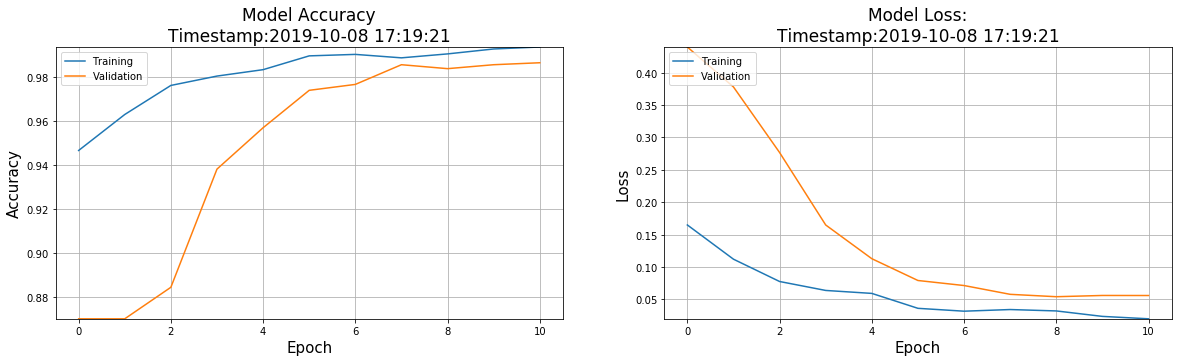

In [22]:
# 可视化
plot_performance(history=cnn_history)

### 导入模型

In [23]:
# model.load_weights("lstm.hdf5")

### 提交结果

In [ ]:
# 数据导入
data = pd.read_csv("./sms_spam/sms_test.txt",encoding="utf-8",header=None,sep="\t",names=["text"])
data.head()

In [ ]:
predict_data = data["text"]

In [ ]:
# 将带预测数据转为序列
predict_sequences = tok.texts_to_sequences(predict_data)
predict_sequences_matrix = sequence.pad_sequences(predict_sequences,maxlen=max_len)

In [ ]:
# 进行预测
# RNN预测
rnn_predict_num = rnn_model.predict_classes(predict_sequences_matrix )
# CNN预测
cnn_predict_num = cnn_model.predict_classes(predict_sequences_matrix)

In [ ]:
# 查看
print(rnn_predict_num[:10])
print(cnn_predict_num[:10])

In [ ]:
# 生成id
id = np.arange(0,len(data))
id += 1

# 生成提交文件
cnn_df = pd.DataFrame({"id":id,"predict":cnn_predict_num[:,0]})
cnn_df.to_csv("cnn_submit.csv",index=None)

rnn_df = pd.DataFrame({"id":id,"predict":rnn_predict_num[:,0]})
rnn_df.to_csv("rnn_submit.csv",index=None)